Epoch [1/100], Loss: 1.001281276345253
Epoch [2/100], Loss: 0.9990648776292801
Epoch [3/100], Loss: 1.000503957271576
Epoch [4/100], Loss: 1.0019550770521164
Epoch [5/100], Loss: 0.9983748197555542
Epoch [6/100], Loss: 1.0052646547555923
Epoch [7/100], Loss: 0.9928858131170273
Epoch [8/100], Loss: 0.9955648183822632
Epoch [9/100], Loss: 0.9938906729221344
Epoch [10/100], Loss: 0.9865680187940598
Epoch [11/100], Loss: 0.9803203046321869
Epoch [12/100], Loss: 0.9866641461849213
Epoch [13/100], Loss: 0.9796354472637177
Epoch [14/100], Loss: 0.9731796681880951
Epoch [15/100], Loss: 0.9712928831577301
Epoch [16/100], Loss: 0.9651604145765305
Epoch [17/100], Loss: 0.9641905128955841
Epoch [18/100], Loss: 0.9616133570671082
Epoch [19/100], Loss: 0.9498913288116455
Epoch [20/100], Loss: 0.9585480093955994
Epoch [21/100], Loss: 0.9625442922115326
Epoch [22/100], Loss: 0.9478814005851746
Epoch [23/100], Loss: 0.9591749906539917
Epoch [24/100], Loss: 0.9523235708475113
Epoch [25/100], Loss: 0.958

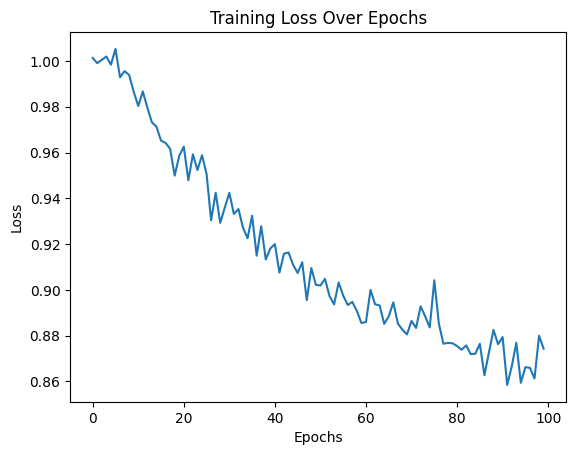

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from utils.calculations import calculate_local_entropy, apply_noise_based_on_randomness
from utils.gaussian_diffusion import GaussianDiffusion

class UNetDenoiser(nn.Module):
    def __init__(self, img_channels=3, base_channels=64):
        super(UNetDenoiser, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, base_channels, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1),
            nn.ReLU(True)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, 1, 1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(base_channels * 2, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=False, transform=transform)

sample_indices = list(range(100))
cropped_trainset = Subset(trainset, sample_indices)

trainloader = DataLoader(cropped_trainset, batch_size=32, shuffle=True)

diffusion = GaussianDiffusion(img_size=(3, 32, 32), timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')
denoising_model = UNetDenoiser().to('cpu')
optimizer = optim.Adam(denoising_model.parameters(), lr=0.0002)
criterion = nn.MSELoss()

def train_model(diffusion, model, trainloader, epochs=10, max_timesteps=1000, patch_size=8):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, _) in enumerate(trainloader):
            images = images.to('cpu')
            t = torch.randint(0, max_timesteps, (images.size(0),), device='cpu').long()
            noisy_images, noise = diffusion.forward_diffusion(images, t)
            noisy_images_patchwise = []
            for img in images:
                randomness_map = calculate_local_entropy(img, patch_size)
                noisy_image_patchwise = apply_noise_based_on_randomness(img, diffusion, randomness_map, patch_size, max_timesteps)
                noisy_images_patchwise.append(noisy_image_patchwise.unsqueeze(0))
            noisy_images_patchwise = torch.cat(noisy_images_patchwise, dim=0)
            noisy_images_combined = torch.cat([noisy_images, noisy_images_patchwise], dim=0)
            optimizer.zero_grad()
            predicted_noise = model(noisy_images_combined)
            combined_noise = torch.cat([noise, noise], dim=0)
            loss = criterion(predicted_noise, combined_noise)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}")

    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

train_model(diffusion, denoising_model, trainloader, epochs=100)

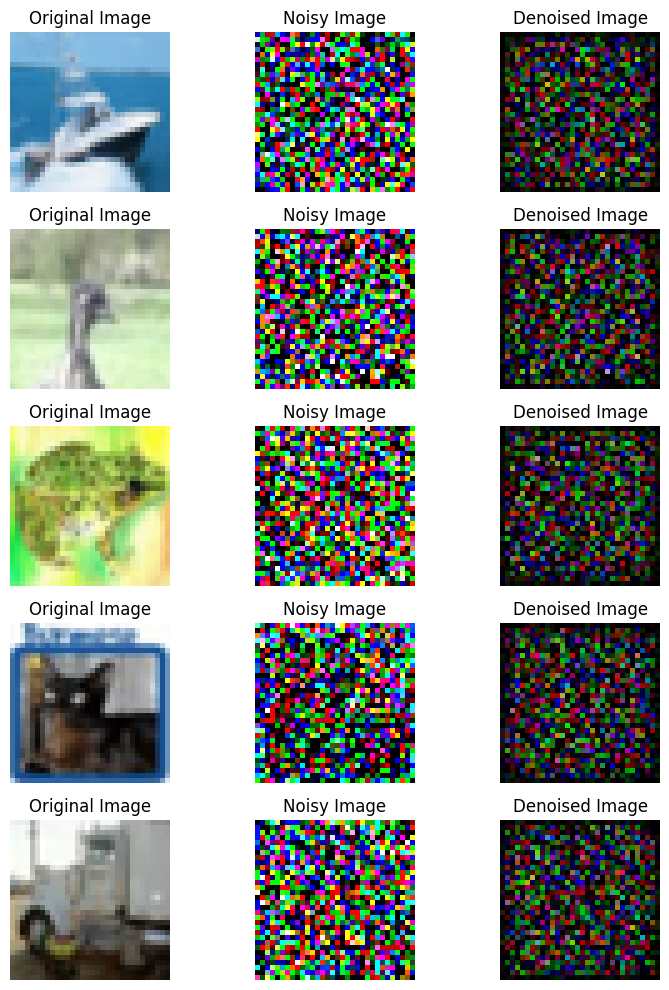

In [57]:
import matplotlib.pyplot as plt

def generate_and_plot_samples(diffusion, model, num_samples=5, max_timesteps=1000):
    model.eval()
    
    with torch.no_grad():
        sample_indices = torch.randint(0, len(cropped_trainset), (num_samples,))
        samples, _ = zip(*[cropped_trainset[i] for i in sample_indices])

        samples = torch.stack(samples).to('cpu')
        
        t = torch.randint(0, max_timesteps, (num_samples,), device='cpu').long()
        noisy_images, _ = diffusion.forward_diffusion(samples, t)

        denoised_images = model(noisy_images)

        fig, axes = plt.subplots(num_samples, 3, figsize=(8, num_samples * 2))

        for i in range(num_samples):
            axes[i, 0].imshow(samples[i].permute(1, 2, 0) / 2 + 0.5)  # Normalize for visualization
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(noisy_images[i].permute(1, 2, 0).clamp(0, 1))  # Clamp for visualization
            axes[i, 1].set_title("Noisy Image")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(denoised_images[i].permute(1, 2, 0).clamp(0, 1))  # Clamp for visualization
            axes[i, 2].set_title("Denoised Image")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()

generate_and_plot_samples(diffusion, denoising_model, num_samples=5)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

from utils.calculations import calculate_local_entropy, apply_noise_based_on_randomness

from utils.gaussian_diffusion import GaussianDiffusion

class SimpleDenoisingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleDenoisingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 3 * 32 * 32  # CIFAR-10 image size
hidden_dim = 128
output_dim = 3 * 32 * 32

denoising_model = SimpleDenoisingModel(input_dim, hidden_dim, output_dim).to('cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=0.01)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=False, transform=transform)

sample_indices = list(range(100))
cropped_trainset = Subset(trainset, sample_indices)

# trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
trainloader = DataLoader(cropped_trainset, batch_size=32, shuffle=True)

diffusion = GaussianDiffusion(img_size=(3, 32, 32), timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')

Epoch [1/100], Loss: 1.0107502341270447
Epoch [2/100], Loss: 1.0069683194160461
Epoch [3/100], Loss: 1.002071052789688
Epoch [4/100], Loss: 1.0065509378910065
Epoch [5/100], Loss: 0.997287854552269
Epoch [6/100], Loss: 1.0019918382167816
Epoch [7/100], Loss: 1.0048672407865524
Epoch [8/100], Loss: 0.9984041601419449
Epoch [9/100], Loss: 1.0018657445907593
Epoch [10/100], Loss: 1.0072352290153503
Epoch [11/100], Loss: 1.0055376440286636
Epoch [12/100], Loss: 1.0038247853517532
Epoch [13/100], Loss: 1.0055551081895828
Epoch [14/100], Loss: 1.000879481434822
Epoch [15/100], Loss: 1.000314250588417
Epoch [16/100], Loss: 1.0101622343063354
Epoch [17/100], Loss: 1.005387082695961
Epoch [18/100], Loss: 0.9985274523496628
Epoch [19/100], Loss: 0.9981802403926849
Epoch [20/100], Loss: 1.0031760931015015
Epoch [21/100], Loss: 1.0025191456079483
Epoch [22/100], Loss: 1.0010351985692978
Epoch [23/100], Loss: 1.0001927763223648
Epoch [24/100], Loss: 1.0066464245319366
Epoch [25/100], Loss: 1.001035

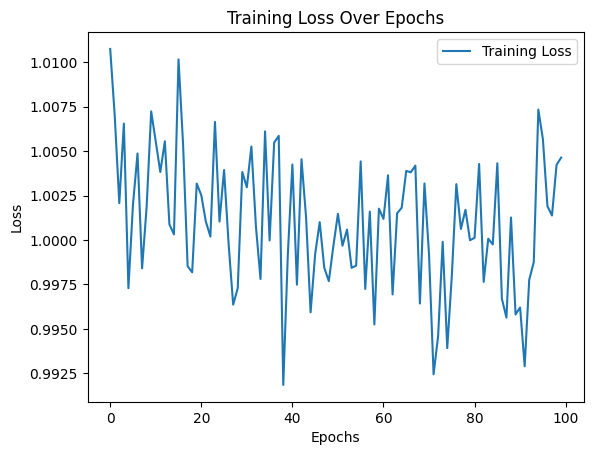

In [46]:
import matplotlib.pyplot as plt

def train_model(diffusion, model, trainloader, epochs=5, patch_size=8, max_timesteps=500):
    loss_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in trainloader:
            images = images.view(images.size(0), -1).to('cpu')

            noisy_images_patchwise = []
            for img in images:
                randomness_map = calculate_local_entropy(img.view(3, 32, 32), patch_size)
                noisy_image_patchwise = apply_noise_based_on_randomness(img.view(3, 32, 32), diffusion, randomness_map, patch_size, max_timesteps)
                noisy_images_patchwise.append(noisy_image_patchwise.view(-1))

            noisy_images_patchwise = torch.stack(noisy_images_patchwise, dim=0)

            optimizer.zero_grad()
            predicted_noise = model(noisy_images_patchwise)

            t = torch.randint(0, max_timesteps, (images.size(0),), device='cpu').long()
            _, noise = diffusion.forward_diffusion(images, t)

            loss = criterion(predicted_noise, noise.view(images.size(0), -1)) 
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        loss_values.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")

    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

train_model(diffusion, denoising_model, trainloader, epochs=100)

In [49]:
def generate_samples(model, num_samples=10, img_size=(3, 32, 32)):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, img_size[0] * img_size[1] * img_size[2]).to('cpu')
        generated_images = model(noise)
        generated_images = generated_images.view(num_samples, *img_size).cpu().numpy()

    return generated_images

def show_samples(samples, num_samples=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(samples[i].transpose(1, 2, 0) * 0.5 + 0.5)  # Rescale to [0, 1] for visualization
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generated_samples = generate_samples(denoising_model, num_samples=10)
show_samples(generated_samples)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [10, 3072]